# Uncertainty quantification of CFD simulations

In [1]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install equadratures # for standard pip install
  #!pip install git+https://github.com/Effective-Quadratures/Effective-Quadratures.git@master # for specific branch

import numpy as np                                                                                                                                                                                      
import matplotlib.pyplot as plt
from equadratures import *
import scipy as sp
from ipywidgets import *
from copy import deepcopy
%matplotlib inline

## A 1D analytical example

To start, lets define a simple 1D quadratic function to act as our model.

In [197]:
our_function = lambda s: -s**2 + s + 1 

We have uncertainty in our definition of $s$, i.e. we only know that it lies between 0 and 1 (hence a uniform pdf). We wish to know what the uncertainty in our model output $y=f(s)$ is due to this uncertainty in $s$. We are only interested in the first two moments of the output here, the mean $\bar{y}$ and variance $Var(y)$.

### Random sampling
One approach to determining $\bar{y}$ and $Var(y)$ is a Monte Carlo type method, where we evaulate the model $f(s)$ at `N` number of randomly sampled points $s$. 

In [198]:
N = 50

def sample_function(N,f):
    # np.random.uniform(low=L,high=H,size=N) will generate a numpy ndarray with N samples between L and H
    s1_samples = np.random.uniform(low=0,high=1,size=N)

    # Evaluate f(s) at the points contained in s1_samples
    #y_samples = our_function(s1_samples)
    y_samples = f(s1_samples)

    # Plot our_function and the discreet samples
    s = np.array(np.linspace(0,1,50))
    plt.plot(s,f(s),lw=5,alpha=0.4)
    plt.plot(s1_samples,y_samples,'xr',ms=8)
    plt.xlabel('$s$',fontsize=15)
    plt.ylabel('$f(s)$',fontsize=15)
    plt.show()

    # Print out the mean and variance of our sample distribution y_samples
    mean = np.mean(y_samples)
    var = np.var(y_samples)
    print('Mean = %.4f, Variance = %.6f' %(mean, var))
    true_mean = sp.integrate.quad(f, 0, 1)[0]
    true_var = sp.integrate.quad(lambda s: f(s)**2, 0, 1)[0] -true_mean**2
    print('Error in mean = %.1f%%, Error in variance = %.1f%%' %(100*(mean-true_mean)/true_mean, 100*(var-true_var)/true_var))
w=interact_manual(sample_function,N=IntSlider(min=5, max=1000),f=fixed(our_function))

interactive(children=(IntSlider(value=5, description='N', max=1000, min=5), Button(description='Run Interact',…

You can vary $N$ above. You should find that you need a relatively large $N$ for $\bar{y}$ and $Var(y)$ to converge, and we're still only in one dimension! For reference, the analytical values are $\bar{y}=1.1\dot{6}$ and $Var(y)=0.00\dot{5}$.

### Computing moments with EQ

Lets now use Effective Quadratures instead. As will become apparent, this involves defining: 
1. **Parameter(s)** 
2. **Basis**
3. **Polynomial**

(see https://www.effective-quadratures.org/_documentation/modules.html)

Start by defining a parameter with a ``uniform`` distribution between 0 and 1.

In [199]:
s1 = Parameter(distribution='uniform', lower=0., upper=1., order=2)

We only have one parameter so we select univariate basis.

In [200]:
mybasis = Basis('univariate')

Now lets define our **polynomial**. The simplest ``method`` for computing the coefficients associated with this polynomial is via ``numerical-integration``. The code will use a tensor product Gaussian quadrature formula to estimate each coefficient of the underlying polynomial expansion. 

In [201]:
mypoly = Poly(parameters=s1, basis=mybasis, method='numerical-integration')

We now need to call `mypoly.set_model()` to feed `mypoly` the training data so it can calculate the polynomial coefficients. We could do this by first getting the quadrature points with `pts = mypoly.get_points()`, then evaluating the function at these points `fs=our_function(pts)`, and finally passing this to `set_model` with `mypoly.set_model(fs)`. Alternatively we can pass `set_model()` our function directly, and it will do all this behind the scenes. 

In [202]:
mypoly.set_model(our_function)

Home stretch! We now have a polynomial "fit". Lets get it from ``mypoly`` with ``get_polyfit``, and plot it. 

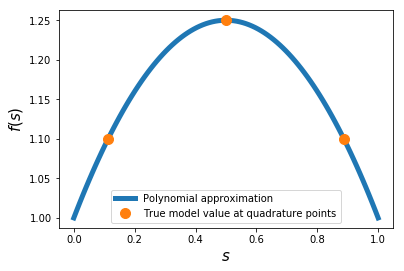

In [203]:
# Get the polyfit function from mypoly
mypolyfit = mypoly.get_polyfit

# Evaluate mypolyfit over 100 points between s1.lower and s2.upper (for plotting only!)
x = np.linspace(s1.lower,s1.upper,100)
y = mypolyfit(x)
plt.plot(x,y,lw=5,label='Polynomial approximation')

# Evaluate our_function at the quadrature points
pts = mypoly.get_points()
plt.plot(pts,our_function(pts),'o',ms=10,label='True model value at quadrature points')
plt.xlabel('$s$',fontsize=15)
plt.ylabel('$f(s)$',fontsize=15)
plt.legend()
plt.show()

And the *moment* of truth...

In [204]:
mean, var = mypoly.get_mean_and_variance()
print('Mean = %.4f, Variance = %.6f' %(mean,var))
true_mean = sp.integrate.quad(our_function, 0, 1)[0]
true_var = sp.integrate.quad(lambda s: our_function(s)**2, 0, 1)[0] -true_mean**2
print('Error in mean = %.1f%%, Error in variance = %.1f%%' %(100*(mean-true_mean)/true_mean, 100*(var-true_var)/true_var))

Mean = 1.1667, Variance = 0.005556
Error in mean = 0.0%, Error in variance = 0.0%


These values should line up very closely with the analytical values $\bar{y}=1.1\dot{6}$ and $Var(y)=0.00\dot{5}$. This is expected in this case, since our model is a polynomial itself. Notice how we have accurately computing the moments with far fewer model evaluations ($N$) compared to the random sampling approach.

## CFD example: UQ of a turbine blade row


Blah blah blah

Again, we don't have any prior knowledge of what $\hat{\nu}/\nu$ should be, except for that it lies in the range 1 to 100, so lets set it as a uniform distribution.

The turbulence intensity is easier to measure, so could know it is somewhere around $Ti \approx 10\%$ (as an example), but don't have much confidence in this. Therefore lets define it as a Gaussian with mean=10 and variance=5.  

In [205]:
s1 = Parameter(distribution='uniform', lower=1.0, upper=100, order=3) #turb2lamviscosity
s2 = Parameter(distribution='Gaussian', shape_parameter_A=10, shape_parameter_B=5, order=3) #Ti

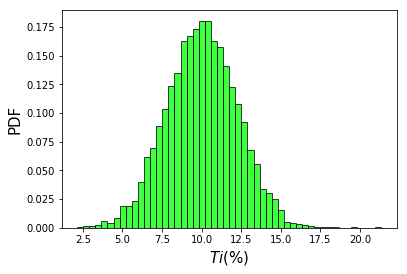

In [206]:
# PDF of s2 is plotted here
z2_samples = s2.get_samples(9000)
n, bins, patches = plt.hist(z2_samples, 50, density=True, facecolor='lime', alpha=0.75, edgecolor='k')
plt.xlabel(r'$Ti (\%)$', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.show()

Next we define a Basis and Poly, like before. This time the problem is bivariate, lets keep it simple and choose a `tensor-grid` basis.

In [207]:
mybasis = Basis('tensor-grid')
mypoly = Poly(parameters=[s1,s2], basis=mybasis, method='numerical-integration')

In the previous example our model was a simple analytical function, which we could pass directly to `set_model` for it to evaluate at the quadrature points. This time, our model is a real CFD simulation. We need to obtain the quadrature points (which are the $\hat{\nu}/\nu$ and $Ti$ inflow conditions for each simulation), and go away and run the CFD. 

Viscosity ratio 	 Ti
[[ 7.87375258  4.78009112]
 [ 7.87375258  8.34091854]
 [ 7.87375258 11.65908146]
 [ 7.87375258 15.21990888]
 [33.67093834  4.78009112]
 [33.67093834  8.34091854]
 [33.67093834 11.65908146]
 [33.67093834 15.21990888]
 [67.32906166  4.78009112]
 [67.32906166  8.34091854]
 [67.32906166 11.65908146]
 [67.32906166 15.21990888]
 [93.12624742  4.78009112]
 [93.12624742  8.34091854]
 [93.12624742 11.65908146]
 [93.12624742 15.21990888]]


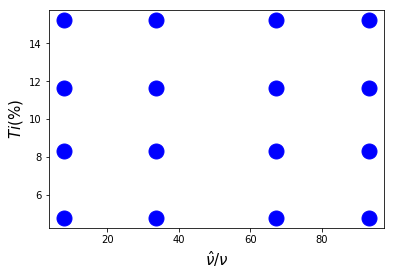

In [208]:
# Get the DOE points
pts = mypoly.get_points()

# Print and save to file
print('Viscosity ratio \t Ti')
print(pts)
np.save('points_to_run.npy', pts)

# Plot the DOE points
plt.plot(pts[:,0], pts[:,1], 'bo', markersize=15)
plt.xlabel(r'$\hat{\nu}/\nu$', fontsize=15)
plt.ylabel(r'$Ti (\%)$', fontsize=15)
plt.show()

The above plot shows our Design of Experiment (DoE). It is relatively straightforward to take the `points_to_run.npy` file and go away and run a set of CFD simulations at these DoE points (especially with the python wrapper functionality of the [SU2](https://su2code.github.io/) CFD code!). The `lossarray_sst.npy` file located in the same directory as this notebook contains the loss coefficient $Y_p$ results obtained by doing exactly this with SU2. 

Lets load up the loss coefficient $Y_p$ values for our DoE, and pass this data to `mypoly` with `set_model`. 

In [209]:
# Load the Yp array from file
if IN_COLAB: 
  !wget https://raw.githubusercontent.com/Effective-Quadratures/EQ-live/master/Blog_posts/lossarray_sst.npy -O lossarray_sst.npy
Yp = np.load('lossarray_sst.npy').reshape(-1, 1)

# Print the Yp array
print('SA ratio \t Ti \t\t Y_p')
print(np.hstack([pts,Yp]))

mypoly.set_model(Yp)

SA ratio 	 Ti 		 Y_p
[[7.87375258e+00 4.78009112e+00 5.30310580e-02]
 [7.87375258e+00 8.34091854e+00 5.28644236e-02]
 [7.87375258e+00 1.16590815e+01 5.26925252e-02]
 [7.87375258e+00 1.52199089e+01 5.24967211e-02]
 [3.36709383e+01 4.78009112e+00 5.32419115e-02]
 [3.36709383e+01 8.34091854e+00 5.32333854e-02]
 [3.36709383e+01 1.16590815e+01 5.30672169e-02]
 [3.36709383e+01 1.52199089e+01 5.28340593e-02]
 [6.73290617e+01 4.78009112e+00 5.32581624e-02]
 [6.73290617e+01 8.34091854e+00 5.33894321e-02]
 [6.73290617e+01 1.16590815e+01 5.32981622e-02]
 [6.73290617e+01 1.52199089e+01 5.30067064e-02]
 [9.31262474e+01 4.78009112e+00 5.32606790e-02]
 [9.31262474e+01 8.34091854e+00 5.34980151e-02]
 [9.31262474e+01 1.16590815e+01 5.34417742e-02]
 [9.31262474e+01 1.52199089e+01 5.32224419e-02]]


Now all that remains is to compute the mean and variance of $Y_p$.

In [210]:
mean, var = mypoly.get_mean_and_variance()
print('Mean Yp = %.2g' %(mean))
print('95%% confidence interval for Yp = %.2g (%.2g%%)' %(1.96*np.sqrt(var),100*1.96*np.sqrt(var)/mean))

Mean Yp = 0.053
95% confidence interval for Yp = 0.00047 (0.88%)


So our 95% confidence interval due to uncertainty in inflow turbulence speficiation is $Y_p\pm 0.00047$. This seems small but is actually 0.88% of the mean $Y_p$ value, so may be significant depending on your use case. 

### Checking the accuracy of the polynomial approximation

A word of warning here. Accurate computed moments rely on the polynomial approximation being accurate. We have ommited checks of the polynomial accuracy so far for brevity, but usually this would be done before we call `get_mean_and_variance`. These checks would usually involve checking the $R^2$ score and/or Root Mean Squared Error (RMSE) at the quadrature points.

In [211]:
y_pred = mypoly.get_polyfit(pts).squeeze()
y_true = Yp.squeeze()
# R2
_,_,r_value,_,_ = sp.stats.linregress(y_pred,y_true)
RMSE = np.sqrt(np.mean((y_pred-y_true)**2))
print('R2 = %.3g, RMSE = %.3g' %(r_value**2,RMSE))

R2 = 1, RMSE = 3.49e-16


So we are happy with the accuracy in this case!

**Note**: Since we have checked accuracy at the quadrature points, these scores can be thought of as *training accuracy* metrics. If we had selected higher `order` parameters we would be at risk of overfitting, and it would important to monitor *test accuracy* by holding out data or using cross validation. This will be the topic of a future blog post!

### Dealing with invalid simulation results

Any CFD practitioner is probably all too familiar with CFD simulations not converging! So what happens to the above procedure in this case? To investigate, we set a number of our DoE samples to NaN.

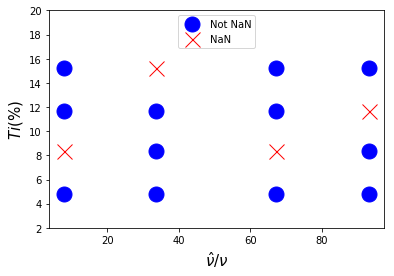

In [212]:
# Enter list of points you want to set to NaN here (0 to 15)
indices = [1,7,9,14]
indices_to_set_to_NaN = np.asarray(indices)

# Set chosen points to NaN
Yp_with_NaNs = deepcopy(Yp)
Yp_with_NaNs[indices_to_set_to_NaN] = np.nan * indices_to_set_to_NaN.reshape(len(indices_to_set_to_NaN),1)

# Plot the DOE points
NaN = np.isnan(Yp_with_NaNs).flatten()
plt.plot(pts[~NaN,0], pts[~NaN,1], 'bo', markersize=15,label='Not NaN')
plt.plot(pts[NaN,0], pts[NaN,1], 'rx', markersize=15,label='NaN')
plt.xlabel(r'$\hat{\nu}/\nu$', fontsize=15)
plt.ylabel(r'$Ti (\%)$', fontsize=15)
plt.legend(loc='upper center')
plt.ylim([2,20])
plt.show()

Now pass the ``Yp_with_NaNs`` array to ``mypoly`` with ``set_model()``.

In [213]:
mypoly_NaN = deepcopy(mypoly)
mypoly_NaN.set_model(Yp_with_NaNs)

The code will now use a least-squares technique that will ignore input-output pairs of your model that have NaNs. This will likely compromise computed statistics.


So the code has automatically detected that some of the model evaluations are NaN, and it has switched to a least-squares technique which can cope with missing samples. Lets compute the moments and see how accurate they are compared to the case without NaNs.

In [214]:
# Compute moments
mean_with_NaNs, var_with_NaNs = mypoly_NaN.get_mean_and_variance()

# Print
print('Original  Mean = %.3g, Original  confidence interval = %.3g%%' %(mean,100*1.96*np.sqrt(var)/mean))
print('With NaNs Mean = %.3g, with NaNs confidence interval = %.3g%%' %(mean_with_NaNs,100*1.96*np.sqrt(var_with_NaNs)/mean_with_NaNs))
err_mean = 100.*(mean_with_NaNs-mean)/mean
err_var  = 100.*(var_with_NaNs -var) /var
print('Errors as a %% of original values: mean = %.3f%%, variance = %.3f%%' %(err_mean,err_var))

Original  Mean = 0.0532, Original  confidence interval = 0.881%
With NaNs Mean = 0.0532, with NaNs confidence interval = 0.873%
Errors as a % of original values: mean = 0.019%, variance = -1.755%


So hopefully not too bad! As long as we don't have too many invalid samples...

### Sensitivity analysis

As covered by a previous [blog post](https://discourse.effective-quadratures.org/t/sensitivity-analysis-with-effective-quadratures/30), `get_sobol_indices` computes the Sobol indices, which quantify the sensitivity of the model output to the input parameters. 

We now do this for the first order sobol indices $S_i$.

In [215]:
mypoly.get_sobol_indices(order=1)

{(0,): 0.8402230587096422, (1,): 0.13229796898549417}

Clearly, $Y_p$ is significantly more sensitive to $s_1$ ($\nu_t/\nu$) than $s_2$ ($Ti$). This is potentially a problem when we are looking to run CFD simulations of this nature, since ($\nu_t/\nu$) is more difficult to measure, so we often don't have a good idea of what its value should be. 

### Visualising the response surface

We can obtain a a surrogate model $\hat{f}(s_1,s_2)$ from ``mypoly`` with ``get_polyfit``. Lets plot this to visualise the model's response to our parameters $s_1$ and $s_2$. 

In [2]:
# Get the mypolyfit model
mypolyfit = mypoly.get_polyfit

# Get the sampling points
pts = mypoly.get_points()

# PLOTTING STUFF BELOW - CAN IGNORE!
# Sample the polyfit at N number of points so we can plot it
N = 20
s1_samples = np.linspace(pts[0,0], pts[-1,0], N)
s2_samples = np.linspace(pts[0,1], pts[-1,1], N)
[S1, S2] = np.meshgrid(s1_samples, s2_samples)
S1_vec = np.reshape(S1, (N*N, 1))
S2_vec = np.reshape(S2, (N*N, 1))
samples = np.hstack([S1_vec, S2_vec])
PolyDiscreet = mypolyfit( samples )
PolyDiscreet = np.reshape(PolyDiscreet, (N, N))

# Init a 3d graph
if not IN_COLAB: 
  %matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the discretised poly PolyDiscreet as a surface
surf = ax.plot_surface(S1, S2, PolyDiscreet, rstride=1, cstride=1, cmap=cm.gist_earth, linewidth=0, alpha=0.6, label='Tensor grid')
# Plot the actual doe points as black circles
scatter = ax.scatter(pts[:,0],pts[:,1],Yp, c='k', marker='o')

ax.set_xlabel(r'$\frac{\nu_t}{\nu}$', fontsize=15)
ax.set_ylabel(r'$Ti$ ($\%$)', fontsize=15)
ax.set_zlabel(r'$Y_p$', fontsize=15)
ax.view_init(15, 25)
plt.show()

NameError: name 'mypoly' is not defined